In [1]:
import string
from os.path import join
import glob
import json

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from scipy.stats import spearmanr
from matplotlib.ticker import FormatStrFormatter



from naturalcogsci.helpers import get_project_root

%config InlineBackend.figure_format='retina'

PROJECT_ROOT = get_project_root()

mpl.rcParams.update(mpl.rc_params_from_file(join(PROJECT_ROOT, ".matplotlibrc")))

FIGWIDTH = mpl.rcParams["figure.figsize"][0]
CMAP = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
CATEGORYTRIALS = 120
REWARDTRIALS = 60
SMALL_SIZE = 8
SMALLER_SIZE = 6
BIGGER_SIZE = 12



with open(join(PROJECT_ROOT, "data", "model_plot_params.json")) as f:
    plot_params = json.load(f)
plot_params = {k.replace("/", "_"): v for k, v in plot_params.items()}
main_feature_names = list(plot_params.keys())

In [2]:
dfs = glob.glob(
    join(
        PROJECT_ROOT,
        "data",
        "learner_behavioural",
        "category_learning",
        "*_l2_original.csv",
    )
)
dfs = [pd.read_csv(x) for x in dfs]
model_df = pd.concat(dfs)
model_df["nll"] = -np.where(
    model_df.choice == 1, np.log(model_df.prob),np.log(1 - model_df.prob)
)
model_df = model_df[model_df.features.isin(main_feature_names)]
model_df["return"] = np.where(np.round(model_df.prob) == model_df.true_category_binary, 1, 0)
chance_level = -model_df.participant.nunique() * CATEGORYTRIALS * np.log(0.5)
model_df = model_df.groupby("features").agg({"nll": "sum", "return": "mean"}).reset_index()
model_df = model_df.sort_values(by="nll", ascending=True).reset_index(drop=True)
model_df["color"] = model_df["features"].apply(lambda x: plot_params[x]["colour"])
model_df["feature_key"] = model_df["features"]
model_df["alignment"] = model_df["features"].apply(lambda x: plot_params[x]["alignment"])
model_df["features"] = model_df["features"].apply(lambda x: plot_params[x]["name"])
model_df["nll"] = 1 - model_df.nll/chance_level
model_df.loc[model_df.nll==1]["nll"] = 0
category_model_df = model_df

In [3]:
dfs = glob.glob(
    join(
        PROJECT_ROOT,
        "data",
        "learner_behavioural",
        "reward_learning",
        "*_l2_original.csv",
    )
)
dfs = [pd.read_csv(x) for x in dfs]
model_df = pd.concat(dfs)
model_df = model_df[model_df.features.isin(main_feature_names)]
model_df["prob"] = np.where(model_df.prob == 1, 0.99999, model_df.prob)
model_df["nll"] = -np.where(
    model_df.choice == 1, np.log(model_df.prob), np.log(1 - model_df.prob)
)
chance_level = -model_df.participant.nunique() * REWARDTRIALS * np.log(0.5)
model_df["model_choice"] = np.where(model_df.right_value > model_df.left_value, 1,0)
model_df["best_side"] = np.where(model_df.right_reward > model_df.left_reward, 1, 0)
model_df["return"] = np.where(model_df.model_choice == model_df.best_side,1,0)
model_df = model_df.groupby("features").agg({"nll": "sum", "return": "mean"}).reset_index()
model_df = model_df.sort_values(by="nll", ascending=True).reset_index(drop=True)
model_df["color"] = model_df["features"].apply(lambda x: plot_params[x]["colour"])
model_df["alignment"] = model_df["features"].apply(lambda x: plot_params[x]["alignment"])
model_df["feature_key"] = model_df["features"]
model_df["features"] = model_df["features"].apply(lambda x: plot_params[x]["name"])
model_df["nll"] = 1 - model_df.nll/chance_level
reward_model_df = model_df

In [4]:
merged_df = pd.merge(
    reward_model_df[["features", "color", "nll", "return","feature_key"]],
    category_model_df[["features", "color", "nll", "return","feature_key"]],
    on=["features", "color", "feature_key"],
    suffixes=("_reward", "_category"),
)

peterson_data = json.load(open(join(PROJECT_ROOT,"data","peterson","peterson_correlations.json")))
nights_data = json.load(open(join(PROJECT_ROOT,"data","nights","nights.json")))
harmonization_data ={}
for jfile in glob.glob(join(PROJECT_ROOT,"data","harmonization","*json")):
    f = json.load(open(jfile))
    harmonization_data[f["model_name"]] = f["alignment_score"]

merged_df["nll"] = (merged_df["nll_reward"] + merged_df["nll_category"])/2
merged_df["return"] = (merged_df["return_reward"] + merged_df["return_category"])/2
merged_df.drop(["return_reward", "return_category"], axis=1, inplace=True)
merged_df.drop(["nll_reward", "nll_category"], axis=1, inplace=True)
merged_df["model_size"] = model_df["feature_key"].apply(
    lambda x: plot_params[x]["size"]
)
merged_df["zero_shot"] = model_df["feature_key"].apply(
    lambda x: plot_params[x]["zero-shot"]
)
merged_df["probing"] = model_df["feature_key"].apply(
    lambda x: plot_params[x]["probing"]
)

merged_df["peterson"] = model_df["feature_key"].apply(
    lambda x: peterson_data.get(x, np.nan)
)
merged_df["nights"] = model_df["feature_key"].apply(
    lambda x: nights_data.get(x, np.nan)
)
merged_df["harmonization"] = model_df["feature_key"].apply(
    lambda x: harmonization_data.get(x, np.nan)
)


merged_df["training_data"] = model_df["feature_key"].apply(
    lambda x: plot_params[x]["data-size"]
)


/var/folders/2t/zlktsbp913sc2d_5zx40s3rh0000gn/T/ipykernel_72146/2678745792.py:24: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(data=merged_temp_df,x="zero_shot", y="nll",ax=axs[0],hue="color", edgecolor=CMAP[-1],
/var/folders/2t/zlktsbp913sc2d_5zx40s3rh0000gn/T/ipykernel_72146/2678745792.py:34: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(data=merged_temp_df,x="probing", y="nll",ax=axs[1],hue="color", edgecolor=CMAP[-1],
/var/folders/2t/zlktsbp913sc2d_5zx40s3rh0000gn/T/ipykernel_72146/2678745792.py:46: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(data=peterson_df,x="peterson", y="nll",ax=axs[2],hue="color", edgecolor=CMAP[-1],
/var/folders/2t/zlktsbp913sc2d_5zx40s3rh0000gn/T/ipykernel_72146/2678745792.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

0.009135951067627854
0.0025748101583053886
0.0016408186891398188
0.5573016393362149
0.015545373390900938


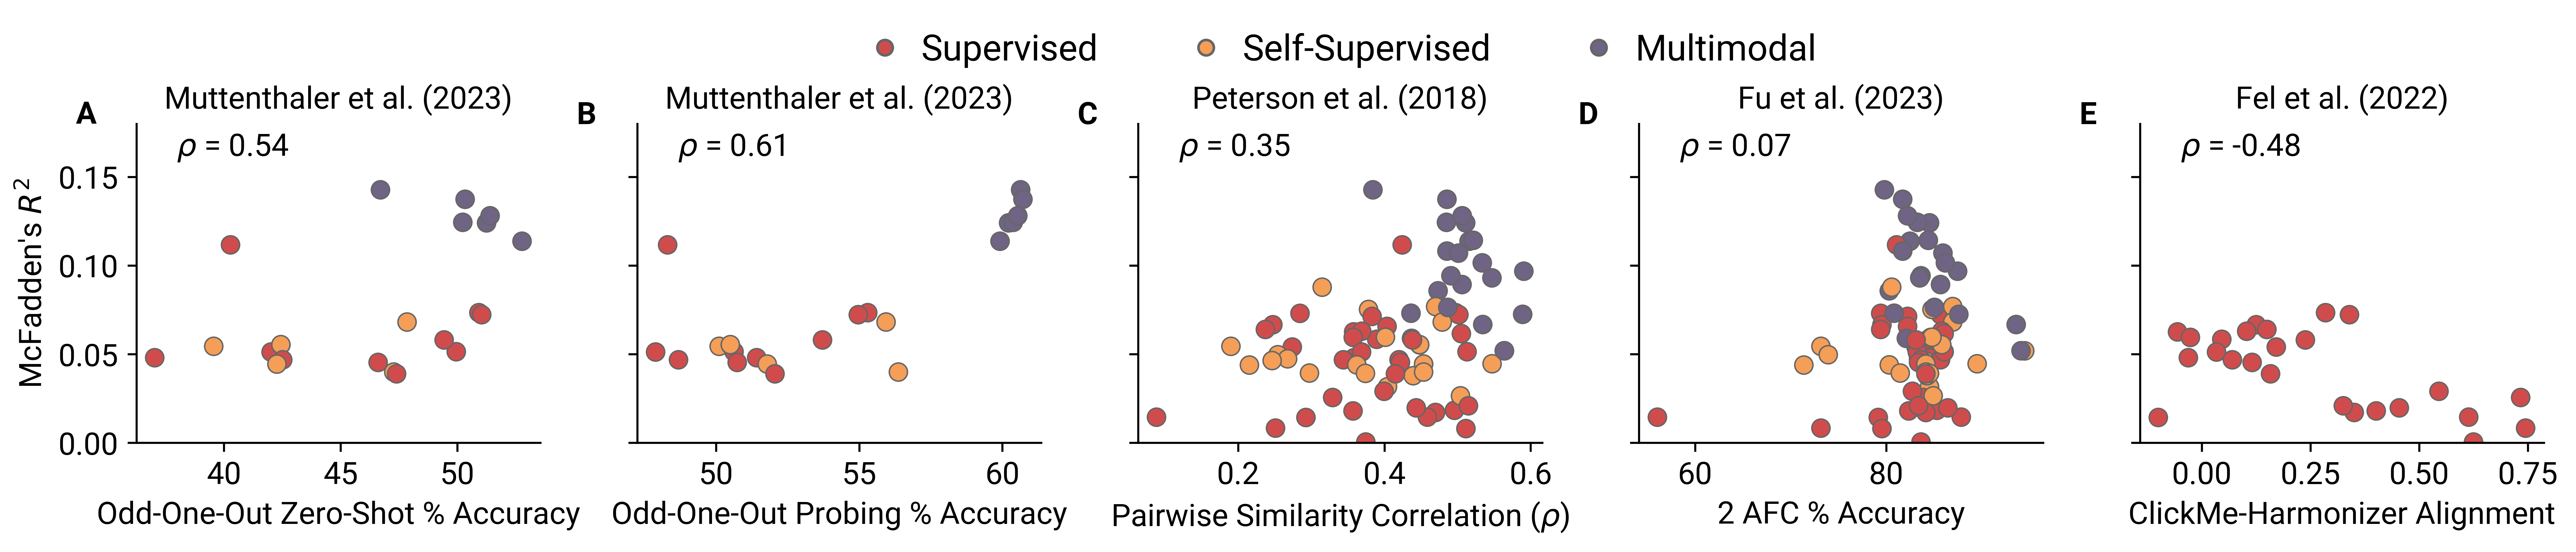

In [5]:

# replace NA with NaN and convert to float
merged_df["zero_shot"] = merged_df["zero_shot"].replace('NA', np.nan).fillna(np.nan).astype(float)
merged_df["probing"] = merged_df["probing"].replace('NA', np.nan).fillna(np.nan).astype(float)

s=50
delta = 4
context_dict = {
    "font.size": SMALL_SIZE +delta,
    "axes.titlesize": SMALL_SIZE + delta,
    "axes.labelsize": SMALL_SIZE + delta,
    "xtick.labelsize": SMALL_SIZE + delta,
    "ytick.labelsize": SMALL_SIZE + delta,
    "legend.fontsize" : SMALL_SIZE + delta + 2,
    "figure.titlesize": BIGGER_SIZE + delta
}
with plt.rc_context(context_dict):

    fig,axs = plt.subplots(1,5,figsize=(2*FIGWIDTH,2*FIGWIDTH/5), sharey=True)

    merged_temp_df = merged_df[~merged_df.zero_shot.isna()]
    merged_temp_df = merged_df[(~merged_df.probing.isna())]

                            
    sns.scatterplot(data=merged_temp_df,x="zero_shot", y="nll",ax=axs[0],hue="color", edgecolor=CMAP[-1],
        hue_order=[
            "supervised",
            "self-supervised",
            "multimodal",
        ],
        palette=CMAP[1:-1],
        legend=False,
        s=s
    )
    sns.scatterplot(data=merged_temp_df,x="probing", y="nll",ax=axs[1],hue="color", edgecolor=CMAP[-1],
        hue_order=[
            "supervised",
            "self-supervised",
            "multimodal",
        ],
        palette=CMAP[1:-1],
        legend=False,
        s=s
    )

    peterson_df = merged_df[~merged_df.peterson.isna()]
    sns.scatterplot(data=peterson_df,x="peterson", y="nll",ax=axs[2],hue="color", edgecolor=CMAP[-1],
        hue_order=[
            "supervised",
            "self-supervised",
            "multimodal",
        ],
        palette=CMAP[1:-1],
        legend=False,
        s=s
    )

    nights_df = merged_df[~merged_df.nights.isna()]
    nights_df["nights"] = merged_df["nights"] * 100
    sns.scatterplot(data=nights_df,x="nights", y="nll",ax=axs[3],hue="color", edgecolor=CMAP[-1],
        hue_order=[
            "supervised",
            "self-supervised",
            "multimodal",
        ],
        palette=CMAP[1:-1],
        legend=False,
        s=s
    )

    sns.scatterplot(data=merged_df[~merged_df.harmonization.isna()],x="harmonization", y="nll",ax=axs[4],hue="color", edgecolor=CMAP[-1],
        hue_order=[
            "supervised",
            "self-supervised",
            "multimodal",
        ],
        palette=CMAP[1:-1],
        legend=False,
        s=s
    )

    axs[0].set_xlabel("Odd-One-Out Zero-Shot % Accuracy")
    axs[1].set_xlabel("Odd-One-Out Probing % Accuracy")
    axs[2].set_xlabel("Pairwise Similarity Correlation "
                    r"($\rho$)")
    axs[3].set_xlabel("2 AFC % Accuracy")
    axs[4].set_xlabel("ClickMe-Harmonizer Alignment")

    axs[0].set_ylabel(r"McFadden's $R^2$")
    for i,ax in enumerate(axs.flatten()):
        ax.text(-0.15, 1.0, string.ascii_uppercase[i], transform=ax.transAxes, weight="bold")


    custom_legend_lines = [
        Line2D(
            [0],
            [0],
            color=x,
            marker="o",
            markeredgecolor=CMAP[-1],
            linestyle="-",
            linewidth=0,
        )
        for x in CMAP[1:4]
    ]
    hue_order = [
        "Supervised",
        "Self-Supervised",
        "Multimodal",
    ]
    fig.legend(
        custom_legend_lines,
        hue_order,
        loc="center",
        bbox_to_anchor=(0.52, 1.),
        ncol=5,
        frameon=False,
        handletextpad=0.01,
    )


    tau, p_value = spearmanr(merged_temp_df["nll"], merged_temp_df["zero_shot"])
    print(p_value)
    axs[0].text(0.1, 0.9, r"$\rho$ = {:.2f}".format(tau), transform=axs[0].transAxes)

    tau, p_value = spearmanr(merged_temp_df["nll"], merged_temp_df["probing"])
    print(p_value)
    axs[1].text(0.1, 0.9, r"$\rho$ = {:.2f}".format(tau), transform=axs[1].transAxes)

    tau, p_value = spearmanr(peterson_df["nll"], peterson_df["peterson"])
    print(p_value)
    axs[2].text(0.1, 0.9, r"$\rho$ = {:.2f}".format(tau), transform=axs[2].transAxes)

    tau, p_value = spearmanr(nights_df["nll"], nights_df["nights"])
    print(p_value)
    axs[3].text(0.1, 0.9, r"$\rho$ = {:.2f}".format(tau), transform=axs[3].transAxes)

    harmonization_df = merged_df[~merged_df.harmonization.isna()]
    tau, p_value = spearmanr(harmonization_df["nll"], harmonization_df["harmonization"])
    print(p_value)
    axs[4].text(0.1, 0.9, r"$\rho$ = {:.2f}".format(tau), transform=axs[4].transAxes)

    axs[0].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    y_ticks = np.array(range(0,16,5))/100
    axs[0].yaxis.set_ticks(y_ticks)
    axs[0].set_ybound(0,.18)



    axs[1].xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

    axs[0].set_title("Muttenthaler et al. (2023)")
    axs[1].set_title("Muttenthaler et al. (2023)")
    axs[2].set_title("Peterson et al. (2018)")
    axs[3].set_title("Fu et al. (2023)")
    axs[4].set_title("Fel et al. (2022)")


    plt.tight_layout()
    plt.show()

    fig.savefig(join(PROJECT_ROOT, "figures","alignment_alignment.pdf"), bbox_inches='tight')

    fig.savefig(join(PROJECT_ROOT, "figures","alignment_alignment.svg"), bbox_inches='tight')

    fig.savefig(join(PROJECT_ROOT, "figures","alignment_alignment.png"), bbox_inches='tight')

In [6]:
aligned_models = [
    "Harmonization_ResNet50",
    "Harmonization_ViT_B16",
    "Harmonization_tiny_ConvNeXT",
    "Harmonization_VGG16",
    "Harmonization_EfficientNetB0",
    "Harmonization_tiny_MaxViT",
    "Harmonization_LeViT_small",
    "DreamSim_open_clip_vitb32",
    "DreamSim_clip_vitb32",
    "DreamSim_dino_vitb16",
    "gLocal_clip_RN50",
    "gLocal_clip_ViT-L_14",
    "gLocal_dinov2-vit-base-p14",
    "gLocal_dinov2-vit-large-p14",
    "gLocal_OpenCLIP_ViT-B-32_laion400m_e32",
    "gLocal_resnet18",
    "gLocal_resnet50"
    ]

base_models = [
    "resnet50",
    "vit_b_16",
    "convnext_tiny",
    "vgg16",
    "efficientnet",
    "maxvit",
    "levit",
    "OpenCLIP_ViT-B-32_laion400m_e32",
    "clip_ViT-B_32",
    "dino-vit-base-p16",
    "clip_RN50",
    "clip_ViT-L_14",
    "dinov2-vit-base-p14",
    "dinov2-vit-large-p14",
    "OpenCLIP_ViT-B-32_laion400m_e32",
    "resnet18",
    "resnet50"
]

alignment_task_df = {
    "Alignment": [],
    "Model" : [],
    "nll" : [],
    "zero_shot": [],
    "probing": [],
    "peterson": [],
    "nights": [],
    "colour": []
}

for aligned, base in zip(aligned_models, base_models):
    print(aligned,base)
    
    alignment_type = aligned.split("_")[0]
    alignment_task_df["Alignment"].append(alignment_type)
    
    alignment_task_df["Model"].append(base)

    delta_nll = merged_df[merged_df.feature_key == aligned]["nll"].values - merged_df[merged_df.feature_key == base]["nll"].values
    alignment_task_df["nll"].append(delta_nll[0])
    

    delta_zero = merged_df[merged_df.feature_key == aligned]["zero_shot"].values - merged_df[merged_df.feature_key == base]["zero_shot"].values
    alignment_task_df["zero_shot"].append(delta_zero[0])

    delta_probing = merged_df[merged_df.feature_key == aligned]["probing"].values - merged_df[merged_df.feature_key == base]["probing"].values
    alignment_task_df["probing"].append(delta_probing[0])

    delta_peterson = merged_df[merged_df.feature_key == aligned]["peterson"].values - merged_df[merged_df.feature_key == base]["peterson"].values
    alignment_task_df["peterson"].append(delta_peterson[0])

    delta_nights = merged_df[merged_df.feature_key == aligned]["nights"].values - merged_df[merged_df.feature_key == base]["nights"].values
    alignment_task_df["nights"].append(delta_nights[0] * 100)

    if ("CLIP" in base) or ("clip" in base):
        alignment_task_df["colour"].append("Multimodal")
    elif "dino" in base:
        alignment_task_df["colour"].append("Self-Supervised")
    else:
        alignment_task_df["colour"].append("Supervised")


alignment_task_df = pd.DataFrame(alignment_task_df)


Harmonization_ResNet50 resnet50
Harmonization_ViT_B16 vit_b_16
Harmonization_tiny_ConvNeXT convnext_tiny
Harmonization_VGG16 vgg16
Harmonization_EfficientNetB0 efficientnet
Harmonization_tiny_MaxViT maxvit
Harmonization_LeViT_small levit
DreamSim_open_clip_vitb32 OpenCLIP_ViT-B-32_laion400m_e32
DreamSim_clip_vitb32 clip_ViT-B_32
DreamSim_dino_vitb16 dino-vit-base-p16
gLocal_clip_RN50 clip_RN50
gLocal_clip_ViT-L_14 clip_ViT-L_14
gLocal_dinov2-vit-base-p14 dinov2-vit-base-p14
gLocal_dinov2-vit-large-p14 dinov2-vit-large-p14
gLocal_OpenCLIP_ViT-B-32_laion400m_e32 OpenCLIP_ViT-B-32_laion400m_e32
gLocal_resnet18 resnet18
gLocal_resnet50 resnet50


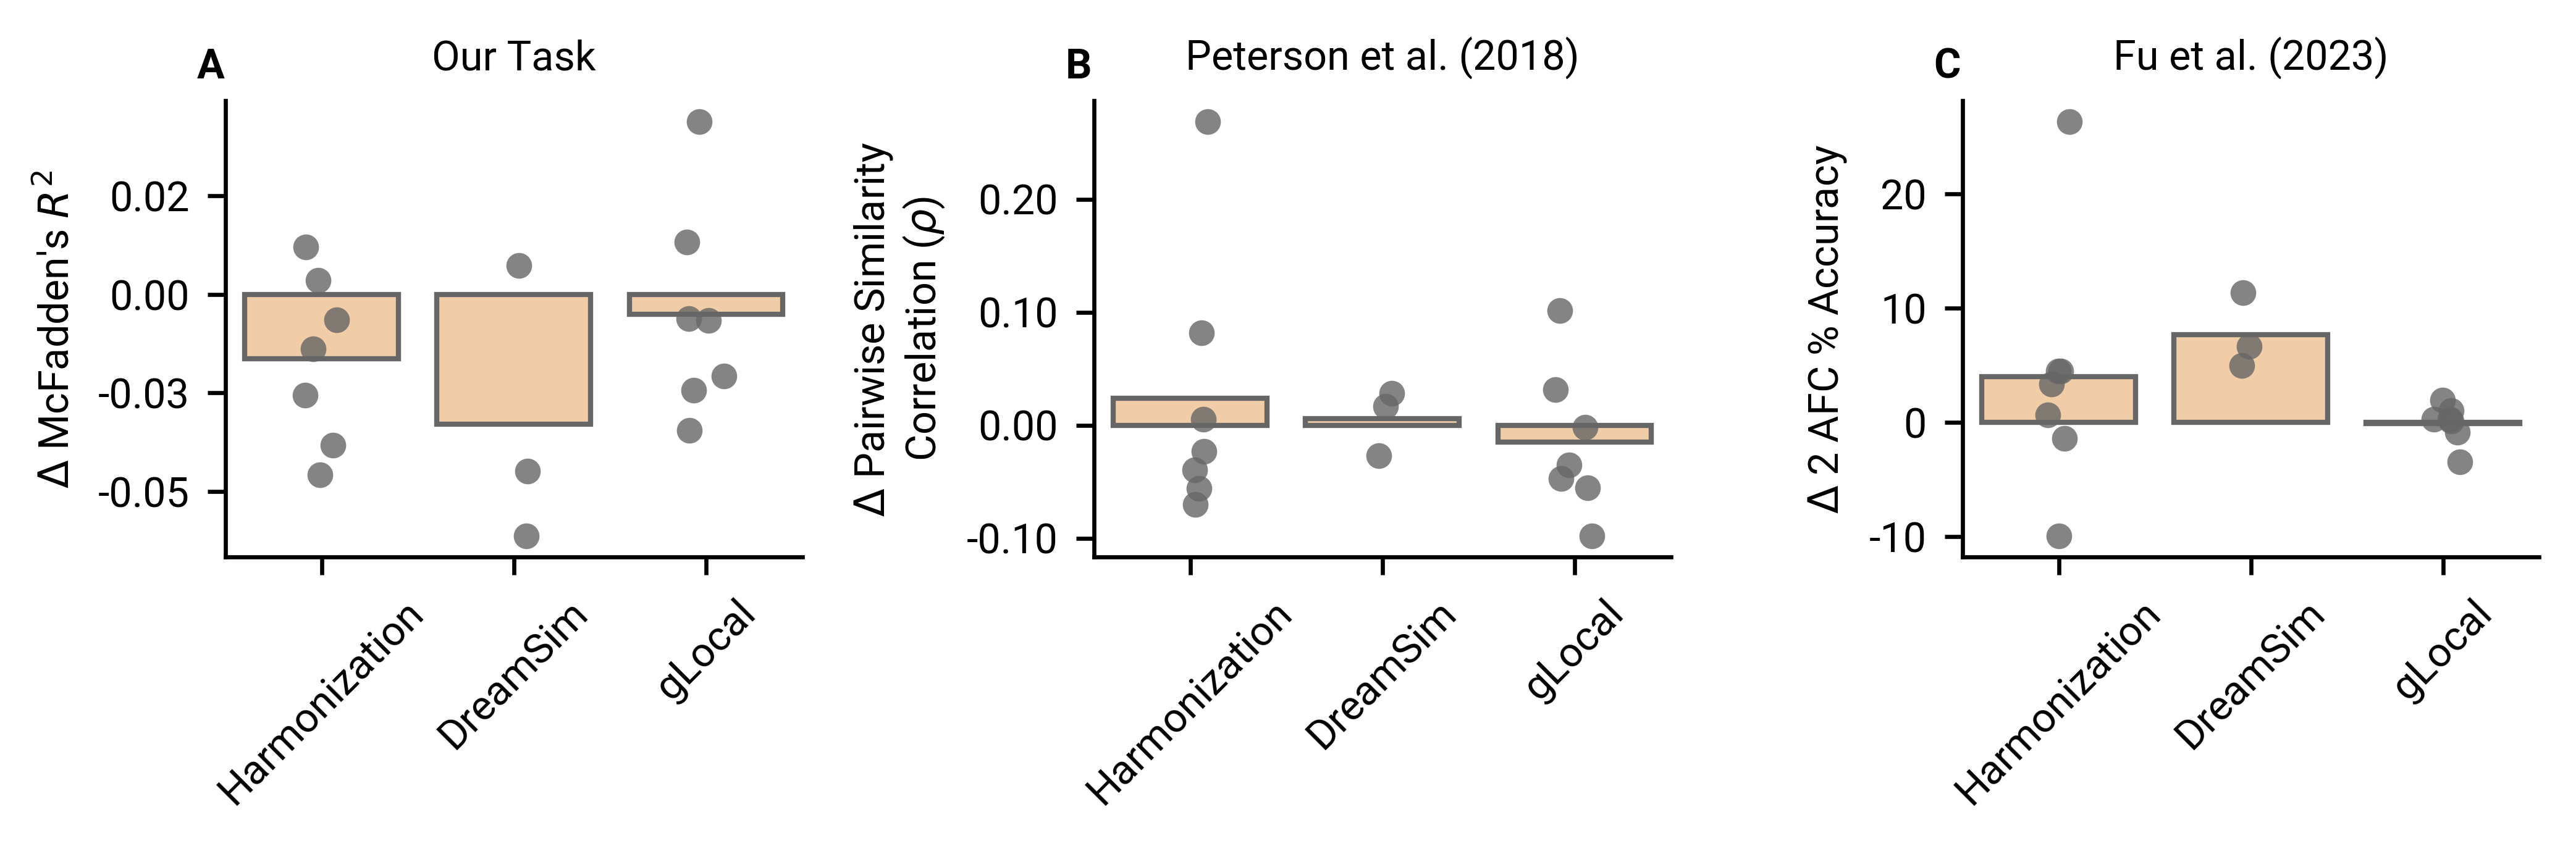

In [7]:
fig, axs = plt.subplots(1,3, figsize=(FIGWIDTH, FIGWIDTH/3))
size=8
sns.barplot(data=alignment_task_df,x="Alignment",y="nll",ax=axs[0],edgecolor=CMAP[-1],color=CMAP[-2],errorbar=None)
sns.stripplot(
    x="Alignment", 
    y="nll", 
    data=alignment_task_df, dodge=True, alpha=0.8, ax=axs[0],color=CMAP[-1]
)
axs[0].set_ylabel(r"$\Delta$ McFadden's $R^2$")

sns.barplot(data=alignment_task_df,x="Alignment",y="peterson",ax=axs[1],edgecolor=CMAP[-1],color=CMAP[-2],errorbar=None)
sns.stripplot(
    x="Alignment", 
    y="peterson", 
    data=alignment_task_df, dodge=True, alpha=0.8, ax=axs[1],color=CMAP[-1]
)
axs[1].set_ylabel(r"$\Delta$ Pairwise Similarity"
                  "\n"
                  r"Correlation ($\rho$)")
#axs[1].set_ylabel("")


axs[0].text(-.05, 1.05, string.ascii_uppercase[0], transform=axs[0].transAxes, weight="bold")
axs[1].text(-.05, 1.05, string.ascii_uppercase[1], transform=axs[1].transAxes, weight="bold")
axs[2].text(-.05, 1.05, string.ascii_uppercase[2], transform=axs[2].transAxes, weight="bold")
# axs[3].text(-.05, 1.05, string.ascii_uppercase[3], transform=axs[3].transAxes, weight="bold")
sns.barplot(data=alignment_task_df,x="Alignment",y="nights",ax=axs[2],edgecolor=CMAP[-1],color=CMAP[-2],errorbar=None)
sns.stripplot(
    x="Alignment", 
    y="nights", 
    data=alignment_task_df, dodge=True, alpha=0.8, ax=axs[2],color=CMAP[-1]
)
axs[2].set_ylabel(r"$\Delta$ 2 AFC % Accuracy")
#axs[2].set_ylabel("")


custom_legend_lines = [
    Line2D(
        [0],
        [0],
        color=x,
        marker="o",
        markeredgecolor=CMAP[-1],
        markersize=size,
        linestyle="-",
        linewidth=0,
    )
    for x in CMAP[1:4]
]




yticklabels = alignment_task_df['Alignment'].drop_duplicates().tolist()

# Set the y-tick labels for the first subplot
#axs[0].set_yticklabels(yticklabels,rotation=45)


for i,ax in enumerate(axs.flatten()):
    ax.set_xlabel("")
    ax.tick_params(axis='x', labelrotation=45)
    if i <= 1:

        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    else:
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))


axs[0].set_title("Our Task")
axs[1].set_title("Peterson et al. (2018)")
axs[2].set_title("Fu et al. (2023)")

plt.tight_layout()
plt.show()


fig.savefig(join(PROJECT_ROOT, "figures","neurips_aligned_models_delta.pdf"), bbox_inches='tight')
fig.savefig(join(PROJECT_ROOT, "figures","neurips_aligned_models_delta.png"), bbox_inches='tight')
fig.savefig(join(PROJECT_ROOT, "figures","neurips_aligned_models_delta.svg"), bbox_inches='tight')